
---

# Setup

---

In [1]:
import os
import time

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from IPython import display
from ipywidgets import interactive
from sklearn.metrics import jaccard_score
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler

# Local project files
from src.VideoDataset import VideoDataset
from src.UNet import UNet
from src.generate_weights import generate_weights
from src.imshow import imshow


---

# Data exploration

---

Load images in, use visual inspection to verify that the labels are matched up with the right images.

### Load files

Not for a PyTorch Dataset, just to explore.

In [2]:
image_dir = os.path.join('.', 'data', 'image')
mask_dir = os.path.join('.', 'data', 'label')

file_dirs = [d for d in os.listdir(mask_dir)]

image_files = sorted([os.path.join(image_dir, fdir, f)
               for fdir in file_dirs
               for f in os.listdir(os.path.join(image_dir, fdir))
               if os.path.splitext(f)[1] == '.png'])
mask_files = sorted([os.path.join(mask_dir, fdir, f)
              for fdir in file_dirs
              for f in os.listdir(os.path.join(mask_dir, fdir))
              if os.path.splitext(f)[1] == '.png'])
n_files = len(image_files)

images = [plt.imread(f)[..., 0] for f in image_files]
masks = [plt.imread(f)[..., 0] > 0.5 for f in mask_files]

assert(n_files == len(mask_files))

print(f'Found {n_files} image+mask pairs')

Found 1583 image+mask pairs


### Investigate array structure

Find datatypes and channel counts for image and mask arrays

In [3]:
image0 = images[0]
print(f'Image 0: {image0.shape} {image0.dtype} {image0.min()}-{image0.max()}')

mask0 = masks[0]
print(f'Mask 0: {mask0.shape} {mask0.dtype}')


Image 0: (480, 640) float32 0.003921568859368563-1.0
Mask 0: (480, 640) bool


### Visualize image+mask pairs

#### Raw data viewer

In [4]:
cmap = plt.get_cmap('plasma')

def visualize_dataset(i, alpha):
    image = images[i]
    mask = masks[i]
    # Color overlay with a mask
    image_rgb = np.stack([image]*3, axis=-1)
    image_rgb[mask > 0, :] = (1 - alpha) * image_rgb[mask > 0, :] \
            + alpha * cmap(mask.astype(float)/2)[mask > 0, :3]
    # Using custom `imshow` in my src folder
    plot_settings = [{'cmap': 'gray'}, {'cmap': 'plasma'}, {}]
    imshow(
        image_rgb, 
        figsize=(6, 6),
        titles=f'Image+Mask {i}')
    return

interactive_visual = interactive(
    visualize_dataset, 
    i=widgets.IntSlider(min=0, max=n_files-1, step=1, value=0, description='Image Index'),
    alpha=widgets.FloatSlider(min=0, max=1, value=1, description='Mask Opacity'))

interactive_visual

interactive(children=(IntSlider(value=0, description='Image Index', max=1582), FloatSlider(value=1.0, descript…

---

# Weight construction

---
Generate class frequency-balancing weights from the cleaned dataset. Weights are stored in a small JSON in the dataset folder, and weight arrays are generated on-the-fly when masks are loaded by the data loader.

For this project, the weight construction algorithm was tested by looking at the output JSON and verifying that the values were normalized inverse frequencies. For a larger project, it would be easy to add a mock dataset to test weight construction algorithms by matching outputs to precomputed values automatically created by the script that builds the mock dataset.

In [5]:
class_weight_file = 'class_weights.json'
dataset_dir = './data'

In [6]:
if class_weight_file not in os.listdir(dataset_dir):
    generate_weights(dataset_dir, n_classes=2)


---

# Dataset construction

---


In [7]:
dataset = VideoDataset(data_dir=dataset_dir)

### Dataset output viewer

This was the extent of the `ChallengeDataset` testing I did for this challenge. For a real project,
it would be easy to also create a mock dataset to test `ChallengeDataset`'s
sample preparation functions. 

For what it's worth, this visual inspector did actually
catch a bug in my `ChallengeDataset` implementation.

In [8]:
mask_cmap = plt.get_cmap('plasma')
weight_cmap = plt.get_cmap('plasma')

def visualize_dataset(i, alpha):
    sample = dataset[i]
    image = np.clip(sample[0], 0, 1)
    mask = sample[1]
    weight = sample[2]
    
    # Overlay 1: Mask
    mask_overlay = np.stack([image]*3, axis=-1)
    mask_overlay[mask > 0, :] = (1 - alpha) * mask_overlay[mask > 0, :] \
            + alpha * mask_cmap(mask.astype(float)/2)[mask > 0, :3]
    
    # Overlay 2: Weight
    # Use log weights for better visualization
    weight_overlay = np.stack([image]*3, axis=-1)
    weight_overlay = (1 - alpha) * weight_overlay \
            + alpha * weight_cmap(weight)[..., :3]
    
    titles = [f'Image+Mask Overlay {i}', f'Image+Weight Overlay {i}']
    
    # Using custom `imshow` in my src folder
    imshow(
        (mask_overlay, weight_overlay), 
        figsize=(12, 6), 
        titles=titles)
    return

interactive_visual = interactive(
    visualize_dataset, 
    i=widgets.IntSlider(min=0, max=len(dataset)-1, step=1, value=0, description='Image Index'),
    alpha=widgets.FloatSlider(min=0, max=1, value=1, description='Mask Opacity'))

interactive_visual

interactive(children=(IntSlider(value=0, description='Image Index', max=1582), FloatSlider(value=1.0, descript…

### Get training and validation splits
Do an 80/20 split since there is not much data.

In [9]:
n_data = len(dataset)

n_train = int(.8 * n_data)
n_val = n_data - n_train


train_dataset, val_dataset = random_split(dataset, (n_train, n_val))

### Build DataLoaders

In [10]:
train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=4)
val_loader = DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=1)

---

# Model construction

---

Using a parametrized UNet class I built a year ago for my (publically available, open-source) lab project repo.

### Device selection
Use the first available GPU.

In [11]:
device = 'cuda'

In [12]:
'''
Implementation of
U-Net: Convolutional Networks for Biomedical Image Segmentation
(Ronneberger et al., 2015)
https://arxiv.org/abs/1505.04597

U-Net with a few added parametrizations to tweak the original model.

Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            n_init_filters (int): number of filters in the first layer
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            instance_norm (bool): Use instance normalization after layers with
                            an activation function.
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
            leaky (bool): If True, use LeakyReLU activation instead of ReLU.

''' 

model = UNet(
    in_channels=1,
    n_classes=2,
    depth=4,
    n_init_filters=16,
    padding=True,
    instance_norm=True,
    up_mode='upconv',
    leaky=True)
model.to(device)

UNet(
  (encoder_module): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
        (4): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
        (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Le


---

# Training setup

---

### Optimizer

In [13]:
optim = torch.optim.Adam(
    model.parameters(),
    lr=10**-3.3,
    weight_decay=1e-5)

### Loss function
Weighted cross-entropy, using the class frequency-balancing weights

In [14]:
def loss_function(prediction, label, weight):
    xentropy = F.cross_entropy(
        prediction, label, reduction='none')
    return torch.sum(torch.mul(weight, xentropy))


---

# Model training

---


### Validation reporting

Every `epochs_per_eval` epochs, print out validation data and a sample validation segmentation

In [15]:
epochs_per_eval = 2

plot_settings = (
        {'cmap': 'gray'},
        {'cmap': 'plasma', 'vmin': 0, 'vmax': 2, 'interpolation': 'nearest'},
        {'cmap': 'plasma', 'vmin': 0, 'vmax': 2, 'interpolation': 'nearest'})

### Main loop

Epoch 1 validation:
  Train time: 24.18s    Val time:  35.02s
  Train loss: 12715.9412    Val loss: 2887.3912    Val MIoU: 0.399


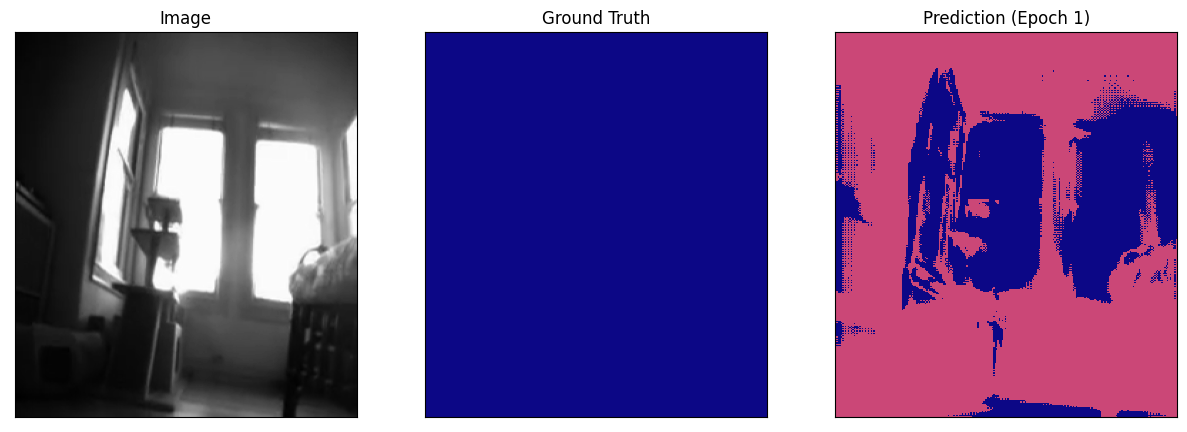

Epoch 3 validation:
  Train time: 23.01s    Val time:  34.00s
  Train loss: 7563.7957    Val loss: 1607.7159    Val MIoU: 0.651


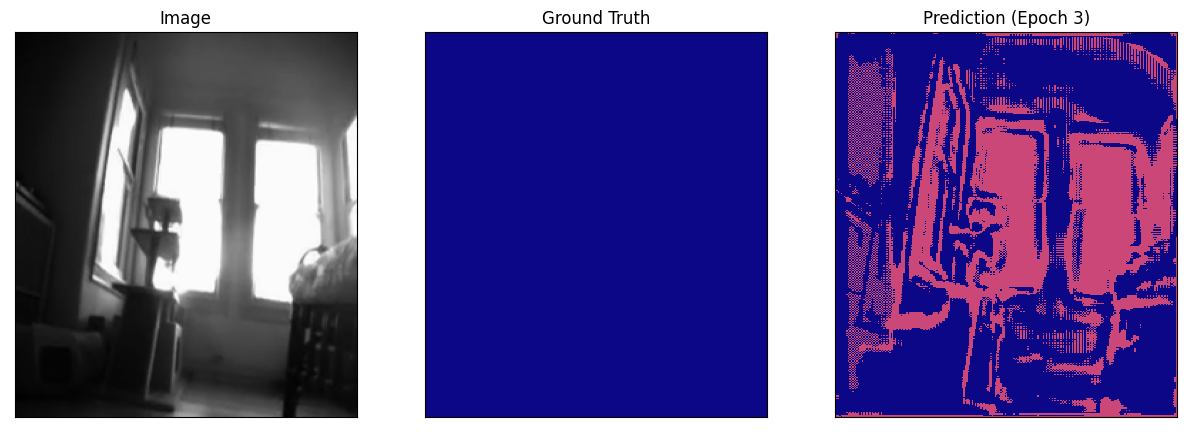

Epoch 5 validation:
  Train time: 22.93s    Val time:  33.74s
  Train loss: 4845.5151    Val loss: 1104.9008    Val MIoU: 0.834


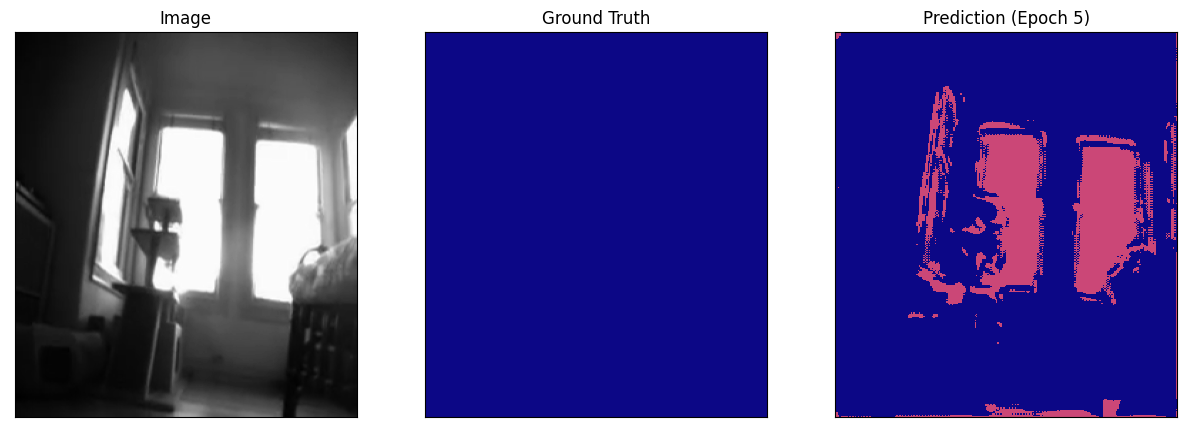

Epoch 7 validation:
  Train time: 23.30s    Val time:  34.32s
  Train loss: 3904.8794    Val loss: 763.3815    Val MIoU: 0.911


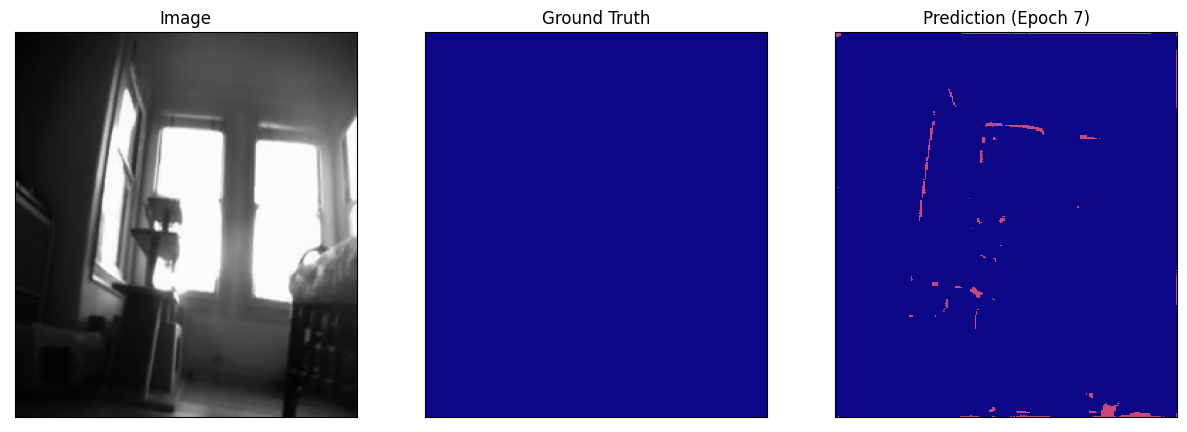

Epoch 9 validation:
  Train time: 23.65s    Val time:  34.63s
  Train loss: 2630.5904    Val loss: 618.2374    Val MIoU: 0.955


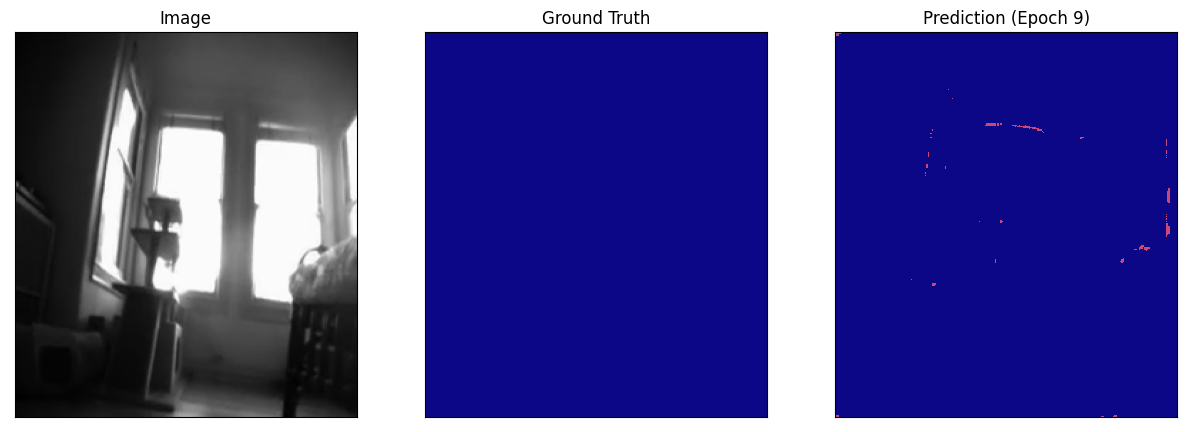

Epoch 11 validation:
  Train time: 23.39s    Val time:  34.24s
  Train loss: 1638.8725    Val loss: 542.9068    Val MIoU: 0.933


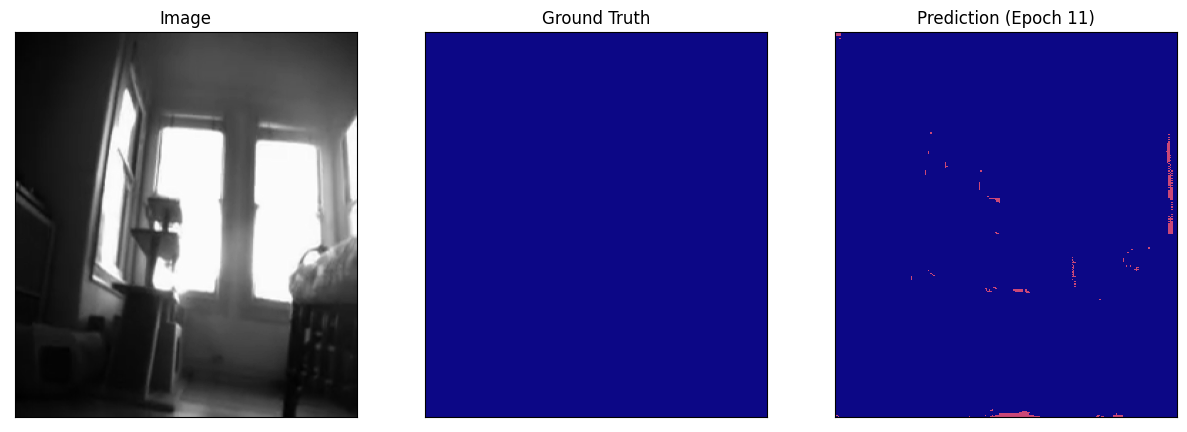

Epoch 12 validation:
  Train time: 23.59s    Val time:  34.77s
  Train loss: 1640.0950    Val loss: 418.3840    Val MIoU: 0.941


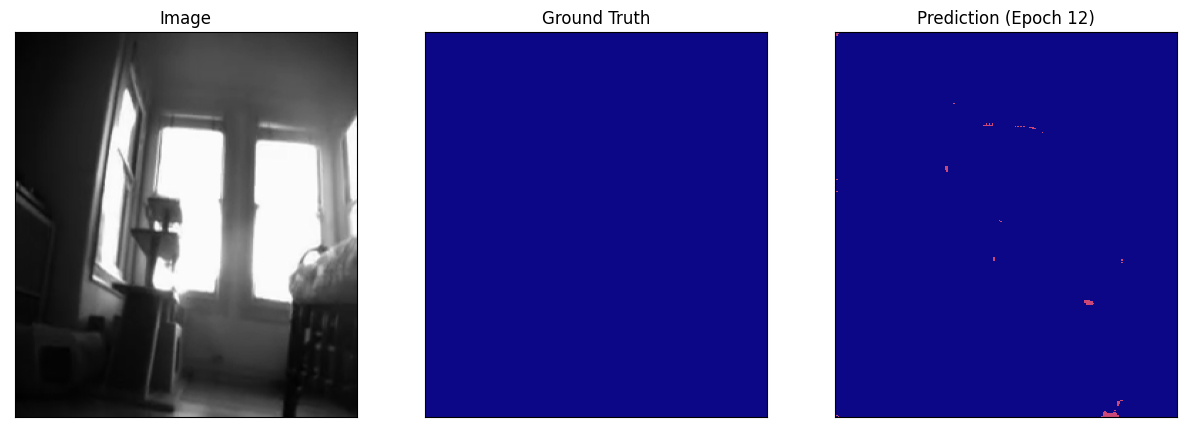

In [16]:
n_epochs = 12

for epoch in range(n_epochs):
    time0 = time.time()
   
    # Train loop
    
    model.train()
    
    losses = []
    
    for i, (image, label, weight) in enumerate(train_loader):
        image = image.to(device).unsqueeze(1)
        label = label.long().to(device)
        weight = weight.to(device)
        
        prediction = model(image)
        
        loss = loss_function(prediction, label, weight)
        losses.append(loss.item())
             
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    train_loss = sum(losses) / len(losses)
    
    time1 = time.time()
    
        
    # Eval loop
    
    if epoch % epochs_per_eval == 0 or epoch == n_epochs - 1:        
        model.eval()
        with torch.no_grad():
            val_losses = []
            predictions = []
            labels = []

            # Produce validation predictions, compute loss and MIoU

            for image, label, weight in val_loader:
                image = image.to(device).unsqueeze(1)
                label = label.long().to(device)
                weight = weight.to(device)

                prediction = model(image)

                classes = torch.argmax(prediction, dim=1).cpu()
                predictions.append(np.squeeze(classes).flatten())
                labels.append(label.cpu().numpy().flatten())

                val_losses.append(loss_function(prediction, label, weight))

            val_loss = sum(val_losses) / len(val_losses)

            miou = jaccard_score(
                np.concatenate(labels).flatten(),
                np.concatenate(predictions).flatten(),
                average='macro')

            time2 = time.time()

            print(f'Epoch {epoch + 1} validation:\n'
                  f'  Train time: {time1 - time0:.2f}s  '
                  f'  Val time:  {time2 - time0:.2f}s\n'
                  f'  Train loss: {train_loss:.4f}  ' 
                  f'  Val loss: {val_loss:.4f}  '
                  f'  Val MIoU: {miou:.3f}')

            images = (
                np.squeeze(image.cpu().numpy()),
                np.squeeze(label.cpu().numpy()),
                np.squeeze(classes.numpy()))

            imshow(
                images, 
                figsize=(15, 5), 
                plot_settings=plot_settings,
                titles=('Image', 'Ground Truth', f'Prediction (Epoch {epoch + 1})'))
            plt.show()        
    